In [1]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
import datetime

In [2]:
# data load
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt4_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)

In [3]:
scrapevar.keys()

dict_keys(['links', 'pubdates', 'titles', 'blurbs', 'sources'])

In [5]:
all_sources = []
for curr_name in scrapevar['sources']:
    for curr_source in scrapevar['sources'][curr_name]:
        all_sources.append(curr_source)

In [6]:
len(all_sources)

36174

In [5]:
source_counts = Counter(all_sources)
df = pd.DataFrame.from_dict(source_counts, orient='index')
col = list(df)

Text(0,0.5,'Number of articles')

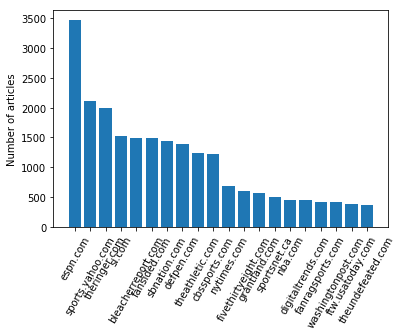

In [7]:
# Plot top 10 number of articles
a = df.sort_values(by=col[0],ascending=False)
name_sites_sorted = list(a[0].index)
narticles_sites_sorted = list(a[0].values)
nplot = 20
plt.bar(name_sites_sorted[0:nplot], narticles_sites_sorted[0:nplot], align='center')
plt.xticks(rotation=60)
plt.ylabel('Number of articles')


In [7]:
# get_proxies():
def get_proxies(nprox):
    url = 'https://free-proxy-list.net/'
    response = requests.get(url)
    curr_soup = BeautifulSoup(response.text)
    rand_ipadd = []
    alllist = curr_soup.findAll("tr")
    # alllist[1].next.text
    rvec = random.sample(range(1, 15), nprox)
    for i in rvec:
        rand_ipadd.append((alllist[i].next.text + ":" + alllist[i].next.next.next.text))
    return rand_ipadd

def get_user_agents(nagents):
    useragent_add = 'https://developers.whatismybrowser.com/useragents/explore/software_type_specific/web-browser/'
    page = requests.get(useragent_add)
    curr_soup = BeautifulSoup(page.text)
    rand_useragents = []
    alllist = curr_soup.findAll("td", {"class": "useragent"})
    rvec = random.sample(range(0, 25), nagents)
    for i in rvec:
        a = alllist[i].find("a")
        rand_useragents.append(a.text)
    return rand_useragents

def build_proxy_agent(proxy_list,user_agent_list):
    proxy = random.choice(proxy_list)
    http_proxy  = "http://" + proxy
    https_proxy = "https://" + proxy

    proxyDict = { 
                  "http"  : http_proxy, 
                  "https" : https_proxy
                }
    user_agent = random.choice(user_agent_list)
    #Set the headers 
    headers = {'User-Agent': user_agent}
    return proxyDict, headers

def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [9]:
proxy_list = get_proxies(12)
user_agent_list = get_user_agents(12)

In [8]:
# grabbing article fn
def grab_espn_article(curr_name,link_idx):
    article_url = scrapevar['links'][curr_name][link_idx]
    article_source = scrapevar['sources'][curr_name][link_idx]
    article_pubdate = scrapevar['pubdates'][curr_name][link_idx]
    page = requests_retry_session(retries=10).get(
        article_url, timeout=10)
    curr_soup = BeautifulSoup(page.text)
    textcontainer = curr_soup.find("article", {"class": "article"})
    textsection = textcontainer.find("div", {"class": "article-body"})
    pgraphs = textsection.findAll("p")
    alltext = ''
    for i in pgraphs:
        alltext = alltext + i.text + ' '
    return article_url, article_source, article_pubdate, alltext

# grab relevant information for article
def grab_article_info(curr_name,link_idx, scrapevar):
    article_url = scrapevar['links'][curr_name][link_idx]
    article_source = scrapevar['sources'][curr_name][link_idx]
    article_pubdate = scrapevar['pubdates'][curr_name][link_idx]
    return article_url, article_source, article_pubdate

In [14]:
# scraping with Newsweek
article_url = scrapevar['links']['zachlowe_nba'][6]
article = Article(article_url)
article.download()
article.parse()
article.text

'Jalen Rose likes the Kawhi Leonard trade for DeMar DeRozan because it gives both San Antonio and Toronto a chance to improve. (1:19)\n\nAt the end of a mid-December practice last season, the five highest-ranking members of Toronto\'s brain trust called DeMar DeRozan into the office of Masai Ujiri, Toronto\'s president of basketball operations, for something of an intervention.\n\n"I didn\'t know what the hell was going on," DeRozan told ESPN a few months later. "I thought, \'S---, I know I can\'t be traded.\' It was like I was being called into the principal\'s office."\n\nUjiri told DeRozan he could be Toronto\'s Kobe Bryant -- a lifetime superstar carrying his team toward title contention -- if he cleared the last hurdle in his game: shooting more 3s. DeRozan started chucking over Toronto\'s next few games, and the Raptors hummed to 59 wins. The story appeared to have ended happily.\n\nBut the team never reached title contention. LeBron humiliated them again. DeRozan was decent in G

In [17]:
sys.getsizeof(article)

56

In [22]:
article2 = grab_espn_article('zachlowe_nba',6)
sys.getsizeof(article2)

80

In [202]:
# attempt to pull espn article
article_url = scrapevar['links']['kevin-arnovitz'][6]
page = requests_retry_session(retries=10).get(
    article_url, timeout=10)
curr_soup = BeautifulSoup(page.text)
textcontainer = curr_soup.find("article", {"class": "article"})
textsection = textcontainer.find("div", {"class": "article-body"})
pgraphs = textsection.findAll("p")
alltext = ''
for i in pgraphs:
    alltext = alltext + i.text + ' '
print(alltext)

The Grizzlies can't -- and probably won't -- get pummeled on the glass as they did in Game 1. The Glass Finding signs of encouragement after a 21-point loss can be like leading a search party in the dark, but if the Grizzlies are looking for some reassurance, it should come in the near certainty that they won’t be outrebounded again by a 2-to-1 margin. If that seemed unprecedented, that's because it was. Memphis didn't come anywhere close to a margin like that in any game during the regular season. There’s a general belief that rebounding doesn’t slump in the NBA. A team like the Grizzlies, which dominated the boards in the regular season (second in overall rebounding rate), doesn’t forget how to ply its trade. Short of injury or a deliberate strategy like a zone defense or fronting the post -- tactics that can make it harder to crash the glass -- a debacle such as Saturday night's is an outlier. The Grizzlies better hope so. They’re not a team endowed with much perimeter firepower or 

In [150]:
# for theringer.com
article_url = scrapevar['links']['jason-concepcion'][6]
print(article_url)
proxyDict, headers = build_proxy_agent(proxy_list,user_agent_list)
page = requests_retry_session(retries=10).get(
                article_url, headers=headers, proxies=proxyDict, timeout=10)
curr_soup = BeautifulSoup(page.text)
textsection = curr_soup.find("div", {"class": "c-entry-content"})
pgraphs = textsection.findAll("p")
alltext = ''
for i in pgraphs:
    alltext = alltext + i.text + ' '
print(alltext)

https://www.theringer.com/binge-mode/2018/9/3/17813820/harry-potter-and-the-order-of-the-phoenix-ch-24-28
Hello! (Yeah!) And welcome to Binge Mode! Mallory Rubin and Jason Concepcion continue their exploration of the Harry Potter universe by diving deep into Harry Potter and the Order of the Phoenix, chapters 24 through 28. To help guide you on that journey, here is a map of the 30th episode of Binge Mode: Harry Potter. It’s not quite as detailed as the Marauder’s Map, but don’t fear: The podcast is just as magical. On Tuesday, Mallory and Jason return for Episode 31 of Binge Mode: Harry Potter, in which they will break down chapters 29 through 33 of Order of the Phoenix. For the full podcast, subscribe on Apple Podcasts, Stitcher, Spotify, or wherever you get podcasts, and follow along on Twitter and join the Facebook group, which is just for Binge Mode fans. We await your digital Owl Post! 


In [204]:
for curr_name in scrapevar['sources']:
    for curr_source in scrapevar['sources'][curr_name]:
        if curr_source == 'bleacherreport.com':
            print(curr_name)

zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
zachlowe_nba
lee-jenkins
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck
howardbeck


In [162]:
# for yahoo sports
article_url = scrapevar['links']['shams-charania'][-1]
print(article_url)
proxyDict, headers = build_proxy_agent(proxy_list,user_agent_list)
page = requests_retry_session(retries=10).get(
                article_url, headers=headers, proxies=proxyDict, timeout=10)
curr_soup = BeautifulSoup(page.text)
textsection = curr_soup.find("article")
pgraphs = textsection.findAll("p")
alltext = ''
for i in pgraphs:
    alltext = alltext + i.text + ' '
print(alltext)

https://sports.yahoo.com/sources-troy-williams-agrees-two-year-deal-knicks-200853056.html
The New York Knicks and forward Troy Williams have agreed to a two-year contract, league sources told Yahoo Sports. Williams’ deal will be guaranteed for the remainder of this season and includes partial guarantees for next season, league sources said. Play Tourney Pick’em | Play against Draymond Green  | Print bracket | What you need to know Williams, an athletic 6-foot-7 wing, has averaged 8.1 points and 2.9 rebounds in 13.9 minutes per game in eight appearances for the Knicks. His second 10-day contract with the team expired on Monday, and the Knicks worked with Williams’ agent, Stephen Pina, to finalize a deal to keep the 23-year-old from entering the offseason as a free agent. Williams is in his second NBA season after going undrafted in 2016 out of Indiana. He joined the Knicks after being released by the Houston Rockets to create roster space for Joe Johnson. More from Yahoo Sports:  • Did 

In [172]:
# for si.com
article_url = scrapevar['links']['ben-golliver'][1]
print(article_url)
proxyDict, headers = build_proxy_agent(proxy_list,user_agent_list)
page = requests_retry_session(retries=10).get(
                article_url, headers=headers, proxies=proxyDict, timeout=10)
curr_soup = BeautifulSoup(page.text)
textsection = curr_soup.find("div", {"id": "article-body"})
if not textsection:
    textsection = curr_soup.find("div", {"id": "longform-body"})
pgraphs = textsection.findAll("p")
alltext = ''
for i in pgraphs:
    alltext = alltext + i.text + ' '
print(alltext)

https://www.si.com/nba/2018/09/10/top-100-nba-players-2019-lebron-james-stephen-curry-dirk-nowitzki
The Crossover is proud to offer our list of the Top 100 NBA players of 2019, an exhaustive exercise that seeks to define who will be the league's best players in the 2018-19 season. Given the wide variety of candidates involved and the deep analytical resources available, no single, definitive criterion was used to form this list. Instead, rankings were assigned based on a fluid combination of subjective assessment and objective data. This list is an attempt to evaluate each player in a vacuum, independent of his current team context as much as possible. A player's prospects beyond the 2018-19 season did not play a part in the ranking process. Injuries and injury risks are an inevitable component of this judgment. Past performance (postseason included) weighed heavily in our assessment, with a skew toward the recent. First-year players were not included. A predictive element also came in

In [185]:
# for fansided.com
article_url = scrapevar['links']['nick-sciria'][1]
print(article_url)
proxyDict, headers = build_proxy_agent(proxy_list,user_agent_list)
page = requests_retry_session(retries=10).get(
                article_url, headers=headers, proxies=proxyDict, timeout=10)
curr_soup = BeautifulSoup(page.text)
textsection = curr_soup.findAll("section", {"class": "article-content"})
alltext = ''
for currsection in textsection:
    pgraphs = currsection.findAll("p")
    for i in pgraphs:
        alltext = alltext + i.text + ' '
    print(alltext)

https://fansided.com/2017/08/29/nylon-calculus-examining-kyrie-irving-celtics-role/
Sometimes, the allure of changing scenery can turn out to be nothing more than a hoax. The newness and unfamiliarity that once seemed so appealing unfolds into the same hidden conflicts and particularly unique challenges of old. However, Kyrie Irving’s new home provides him with a distinctly new world of values and responsibilities, features that could make Irving’s change of scenery well worth it. To demonstrate this difference, let’s compare Kyrie Irving with former Celtics point guard Isaiah Thomas. Despite fairly similar skillsets, an unmistakable contrast emerges when analyzing their respective responsibilities on the offensive end last season. Brad Stevens is, of course, at the heart of this calculated approach, and his creativity has been key in helping Thomas reshape his career. Under Stevens, Boston have embraced an offensive attack that revolves around quick decision making and constant fluidi

In [203]:
# for theathletic.com
article_url = scrapevar['links']['ethan-sherwood-strauss'][9]
print(article_url)
# proxyDict, headers = build_proxy_agent(proxy_list,user_agent_list)
# page = requests_retry_session(retries=10).get(
#                 article_url, headers=headers, proxies=proxyDict, timeout=10)
page = requests.get(article_url, timeout=10)
curr_soup = BeautifulSoup(page.text)
textsection = curr_soup.find("div", {"id": "the_paywall"})
alltext = textsection.text
print(alltext)

https://theathletic.com/422452/2018/07/06/steve-kerr-on-the-warriors-surprise-demarcus-cousins-coup-theres-going-to-be-a-new-dimension/


    I spoke with Steve Kerr about the surprise DeMarcus Cousins signing, some time after Kerr was through with his sojourns up and down Interstate 5 in his son Nick’s Honda. At a point in free agency, Kerr had been called into action away from his San Diego area home and asked to help with a Los Angeles pitch meeting. Along the way, DeMarcus Cousins happened.Perhaps I shouldn’t have been surprised, but what struck me most was Kerr’s beaming enthusiasm for the addition. Professional grumps, coaches are often circumspect about even the most obviously beneficial roster moves. I anticipated more caution, more suppressing of expectations.Instead, Kerr is transparently excited about the possibilities Cousins presents and the problems he might solve. Put another way, the Warriors wish to end switching against Steph Curry as a catch-all strategy. If Cousins 

In [24]:
# for bleacherreport.com
article_url = scrapevar['links']['howardbeck'][1]
article_source = scrapevar['sources']['howardbeck'][1]
article_pubdate = scrapevar['pubdates']['howardbeck'][1]
print(article_url)
# proxyDict, headers = build_proxy_agent(proxy_list,user_agent_list)
# page = requests_retry_session(retries=10).get(
#                 article_url, headers=headers, proxies=proxyDict, timeout=10)
page = requests.get(article_url, timeout=10)
curr_soup = BeautifulSoup(page.text)
textsection = curr_soup.find("div", {"class": "organism contentStream"})
# if not textsection:
#     textsection = curr_soup.find("div", {"id": "longform-body"})
pgraphs = textsection.findAll("p")
alltext = ''
for i in pgraphs:
    alltext = alltext + i.text + ' '
print(alltext)

https://bleacherreport.com/articles/2787074-gregg-popovich-steve-kerr-nba-warriors-spurs-power-50
Steve Kerr did not set out to become an activist. Gregg Popovich did not set out to lead the NBA chapter of the resistance. Neither one has any desire to seek elected office—the #PopKerr2020 campaign notwithstanding. Yet this is where they find themselves: as leading voices for social justice, gun control and general opposition to the policies and excesses of the Donald Trump White House. As prominent, successful NBA coaches, they already had the platform. And while they might never have contemplated using that platform to advance a cause or promote a particular viewpoint, circumstances pushed them here. Gun violence. Police brutality. Racism. Nearly everything Trump has done or said since taking office. The same things that have alarmed much of the populace have caught the attention of Popovich, the San Antonio Spurs head coach, and Kerr, the Golden State Warriors head coach—both of whom 

In [11]:
client = MongoClient()

In [8]:
db = client.test_database
collection = client.test_collection

In [9]:
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [32]:
# try building mongodb
# mydb = client["testinsightdb"]
mydb = client["insightwriterdb"]

In [50]:
# delete db
client.drop_database("testinsightdb")

In [18]:
# scrape but put in scrapevar
scrapevar['articletext'] = {}
scrapevar['articleauth'] = {}
scrapevar['narticle'] = {}
scrapevar['writer_id'] = {}
for curr_name in scrapevar['sources']:
    idx = writer_df['website_name'] == curr_name
    print(curr_name+' '+str(datetime.datetime.now()))
    scrapevar['articletext'][curr_name] = []
    scrapevar['articleauth'][curr_name] = []
    scrapevar['narticle'][curr_name] = []
    scrapevar['writer_id'][curr_name] = []
    rr = []
    for link_idx in range(0,len(scrapevar['links'][curr_name])):
    #     article_url, article_source, article_pubdate, alltext = grab_espn_article(curr_name,link_idx)
        article_url, article_source, article_pubdate = grab_article_info(curr_name,link_idx, scrapevar)
        try:
            article = Article(article_url)
            article.download()
            article.parse()
            article.text
            time.sleep(random.uniform(0.5,1.5))
            scrapevar['articletext'][curr_name].append(article.text)
            scrapevar['articleauth'][curr_name].append(article.authors)
            scrapevar['narticle'][curr_name].append(link_idx)
            scrapevar['writer_id'][curr_name].append(writer_df['Idea ID'][idx].tolist()[0])
#             mydict = { "name": curr_name, "article_url": article_url, "article_source": article_source, 
#                      "pubdates": article_pubdate,"writer_id": writer_df['Idea ID'][idx].tolist()[0], 
#                       "article": article.text, "authors": article.authors, "narticle": link_idx, 
#                      "article_summary": article.summary}
#             x = mycol.insert_one(mydict)
    #         print(x.inserted_id)
        except Exception:
            print(curr_name + ' ' + str(link_idx))
            continue

zachlowe_nba 2018-09-15 21:40:06.745131
Article `download()` failed with 503 Server Error: Service Unavailable: Back-end server is at capacity for url: https://s.washingtonpost.com/camp-rw/?e=bmV3c2xldHRlcnNAd2FzaHBvc3QuY29t&s=58d8fec271885051e1ce94eb on URL https://s.washingtonpost.com/camp-rw/?e=bmV3c2xldHRlcnNAd2FzaHBvc3QuY29t&s=58d8fec271885051e1ce94eb
zachlowe_nba 235
Article `download()` failed with 404 Client Error: Not Found for url: https://www.law.com/id=1202484444959/The-Donald-Trumped-Bondholders-Sideline-Tycoon-and-Tyke-in-Casino-Kafuffle/?slreturn=20180815214903 on URL http://www.americanlawyer.com/id=1202484444959/The-Donald-Trumped-Bondholders-Sideline-Tycoon-and-Tyke-in-Casino-Kafuffle
zachlowe_nba 262
adrian-wojnarowski 2018-09-15 21:56:24.016545
You must `download()` an article first!
adrian-wojnarowski 18
Article `download()` failed with 503 Server Error: Service Unavailable: Back-end server is at capacity for url: https://s.washingtonpost.com/camp-rw/?e=a2FvcmVnbGl

Article `download()` failed with 404 Client Error: Not Found for url: https://sports.yahoo.com/news/ricky-rubio-returns-practice-could-play-vs-clippers-201028431--nba.html on URL http://sports.yahoo.com/news/ricky-rubio-returns-practice-could-play-vs-clippers-201028431--nba.html
adrian-wojnarowski 384
Article `download()` failed with 404 Client Error: Not Found for url: https://sports.yahoo.com/news/nuggets-file-protest-over-last-second-loss-memphis-025910245--nba.html on URL http://sports.yahoo.com/news/nuggets-file-protest-over-last-second-loss-memphis-025910245--nba.html
adrian-wojnarowski 386
Article `download()` failed with 404 Client Error: Not Found for url: https://sports.yahoo.com/news/davis-scores-32-pelicans-beat-bucks-112-106-034353789--nba.html on URL http://sports.yahoo.com/news/davis-scores-32-pelicans-beat-bucks-112-106-034353789--nba.html
adrian-wojnarowski 393
Article `download()` failed with 404 Client Error: Not Found for url: https://sports.yahoo.com/news/wade-winn

Article `download()` failed with 404 Client Error: Not Found for url: https://art19.com/shows/vertical/episodes/f3395737-aa4a-4e77-b11f-491756b5dd45 on URL https://art19.com/shows/vertical/episodes/f3395737-aa4a-4e77-b11f-491756b5dd45
adrian-wojnarowski 466
Article `download()` failed with 404 Client Error: Not Found for url: http://art19.com/shows/vertical/episodes/a52651dd-e8ec-4fbf-a71c-ab55f539374f on URL http://art19.com/shows/vertical/episodes/a52651dd-e8ec-4fbf-a71c-ab55f539374f
adrian-wojnarowski 476
Article `download()` failed with 404 Client Error: Not Found for url: http://art19.com/shows/vertical/episodes/114026a8-eb62-405d-a5c8-e5cf55463363 on URL http://art19.com/shows/vertical/episodes/114026a8-eb62-405d-a5c8-e5cf55463363
adrian-wojnarowski 479
Article `download()` failed with 404 Client Error: Not Found for url: http://art19.com/shows/vertical/episodes/82cb4c11-653b-41f3-980b-ad6d58f59bd9 on URL http://art19.com/shows/vertical/episodes/82cb4c11-653b-41f3-980b-ad6d58f59b

Article `download()` failed with 410 Client Error: Gone for url: http://www.msn.com/en-ca/sports/news/with-promises-kept-lebron-james-has-choices-to-make/ar-AAyoJn3?li=AAggXBR&srcref=rss on URL http://www.msn.com/en-ca/sports/news/with-promises-kept-lebron-james-has-choices-to-make/ar-AAyoJn3?li=AAggXBR&srcref=rss
marc-stein 66
Article `download()` failed with 410 Client Error: Gone for url: http://www.msn.com/en-ca/news/other/with-promises-kept-lebron-james-has-choices-to-make/ar-AAyoJn3?srcref=rss on URL http://www.msn.com/en-ca/news/other/with-promises-kept-lebron-james-has-choices-to-make/ar-AAyoJn3?srcref=rss
marc-stein 68
Article `download()` failed with 410 Client Error: Gone for url: https://www.msn.com/en-us/sports/nba/mike-d%E2%80%99antoni-lost-the-mustache-and-found-himself/ar-AAxK3gk?li=BBnba9I&srcref=rss on URL https://www.msn.com/en-us/sports/nba/mike-d%E2%80%99antoni-lost-the-mustache-and-found-himself/ar-AAxK3gk?li=BBnba9I&srcref=rss
marc-stein 93
Article `download()` f

KeyboardInterrupt: 

In [39]:
# test with some zach lowe stuff
# curr_name = 'zachlowe_nba'
for curr_name in names_still_to_do:
    idx = writer_df['website_name'] == curr_name
    print(curr_name+' '+str(datetime.datetime.now()))
    mycol = mydb[curr_name]
    rr = []
    idfail = 1
    for link_idx in range(0,len(scrapevar['links'][curr_name])):
    #     article_url, article_source, article_pubdate, alltext = grab_espn_article(curr_name,link_idx)
        article_url, article_source, article_pubdate = grab_article_info(curr_name,link_idx, scrapevar)
        try:
            article = Article(article_url)
            article.download()
            article.parse()
            article.text
            time.sleep(random.uniform(0.5,1))
            mydict = { "name": curr_name, "article_url": article_url, "article_source": article_source, 
                     "pubdates": article_pubdate,"writer_id": writer_df['Idea ID'][idx].tolist()[0], 
                      "article": article.text, "authors": article.authors, "narticle": link_idx, 
                     "article_summary": article.summary}
            x = mycol.insert_one(mydict)
    #         print(x.inserted_id)
        except Exception:
            print(curr_name + ' ' + str(link_idx))
            idfail = idfail + 1
            print('fail # ' + str(idfail))
            if idfail > 29:
                print('breaking')
                break
            else:
                continue

apkrawczynski 2018-09-17 07:25:24.300537
apkrawczynski 0
fail # 2
apkrawczynski 1
fail # 3
apkrawczynski 2
fail # 4
apkrawczynski 3
fail # 5
apkrawczynski 4
fail # 6
apkrawczynski 5
fail # 7
apkrawczynski 6
fail # 8
apkrawczynski 7
fail # 9
apkrawczynski 8
fail # 10
apkrawczynski 9
fail # 11
apkrawczynski 10
fail # 12
apkrawczynski 11
fail # 13
apkrawczynski 12
fail # 14
apkrawczynski 13
fail # 15
apkrawczynski 14
fail # 16
apkrawczynski 15
fail # 17
apkrawczynski 16
fail # 18
apkrawczynski 17
fail # 19
apkrawczynski 18
fail # 20
apkrawczynski 19
fail # 21
apkrawczynski 20
fail # 22
apkrawczynski 21
fail # 23
apkrawczynski 22
fail # 24
apkrawczynski 23
fail # 25
apkrawczynski 24
fail # 26
apkrawczynski 25
fail # 27
apkrawczynski 26
fail # 28
apkrawczynski 27
fail # 29
apkrawczynski 28
fail # 30
breaking
dennis-chambers 2018-09-17 07:26:13.394720
glory-okoli 2018-09-17 07:27:36.508138
chris_broussard 2018-09-17 07:27:36.508523
Article `download()` failed with 404 Client Error: Not Found

You must `download()` an article first!
ericpincus 24
fail # 26
You must `download()` an article first!
ericpincus 25
fail # 27
You must `download()` an article first!
ericpincus 26
fail # 28
You must `download()` an article first!
ericpincus 27
fail # 29
You must `download()` an article first!
ericpincus 28
fail # 30
breaking
james-holas 2018-09-17 07:38:02.060495
You must `download()` an article first!
james-holas 0
fail # 2
You must `download()` an article first!
james-holas 1
fail # 3
You must `download()` an article first!
james-holas 2
fail # 4
You must `download()` an article first!
james-holas 3
fail # 5
You must `download()` an article first!
james-holas 4
fail # 6
You must `download()` an article first!
james-holas 5
fail # 7
You must `download()` an article first!
james-holas 6
fail # 8
You must `download()` an article first!
james-holas 7
fail # 9
You must `download()` an article first!
james-holas 8
fail # 10
You must `download()` an article first!
james-holas 9
fail # 11


In [40]:
names_done = mydb.list_collection_names()
names_still_to_do = list(set(scrapevar['sources']) - set(names_done))
print(names_still_to_do)

['sam-esfandiari', 'amin-elhassen', 'editor-dan', 'ja-dubin', 'petervecsey1', 'jeffzillgitt', 'trill-withers', 'ricbucher', 'sebdumitru', 'david-a-morrow', 'jade-hoye', 'senthil-natarajan', 'globebobryan', 'george-rowland', 'scottcacciola', 'apkrawczynski', 'jimmy-spencer-1', 'glory-okoli', 'seerat-sohi', 'albert-nahmad', 'kevin-parrish', 'mika-honkasalo', 'ericpincus', 'james-holas', 'kaileigh-brandt', 'andrew-bernucca', 'keith-smith', 'neil-paine', 'rory-masterson', 'andré-voigt', 'aaron-bruski', 'ti-windisch']


In [37]:
print(names_still_to_do)

['sam-esfandiari', 'amin-elhassen', 'editor-dan', 'ja-dubin', 'petervecsey1', 'jeffzillgitt', 'trill-withers', 'ricbucher', 'sebdumitru', 'david-a-morrow', 'jade-hoye', 'senthil-natarajan', 'globebobryan', 'george-rowland', 'scottcacciola', 'apkrawczynski', 'dennis-chambers', 'glory-okoli', 'chris_broussard', 'jimmy-spencer-1', 'seerat-sohi', 'albert-nahmad', 'kevin-parrish', 'mika-honkasalo', 'ericpincus', 'james-holas', 'kaileigh-brandt', 'andrew-bernucca', 'keith-smith', 'neil-paine', 'rory-masterson', 'andré-voigt', 'aaron-bruski', 'ti-windisch']


In [83]:
# try analyzing data
client = MongoClient()
mydb = client["testinsightdb"]

In [38]:
names_still_to_do = ['apkrawczynski', 'dennis-chambers', 'glory-okoli', 'chris_broussard', 'jimmy-spencer-1', 'seerat-sohi', 'albert-nahmad', 'kevin-parrish', 'mika-honkasalo', 'ericpincus', 'james-holas', 'kaileigh-brandt', 'andrew-bernucca', 'keith-smith', 'neil-paine', 'rory-masterson', 'andré-voigt', 'aaron-bruski', 'ti-windisch']

In [84]:
mycol = mydb['zachlowe_nba']
print(mycol)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'testinsightdb'), 'skip-bayless')


In [143]:
# functions for preprocessing

# standardize text
def standardize_text(df, text_field):
    df[text_field] = df[text_field].replace(r"http\S+", "")
    df[text_field] = df[text_field].replace(r"http", "")
    df[text_field] = df[text_field].replace(r"@\S+", "")
    df[text_field] = df[text_field].replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].replace(r"@", "at")
    df[text_field] = df[text_field].replace(r"[\n\r]+","")
    df[text_field] = df[text_field].replace(r"\n\s*\n","")
    df[text_field] = df[text_field].lower()
#     re.sub(r'(\n+)(?=[A-Z])', r'____', i)
    return df

def clean_text(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

In [101]:
currcol = mydb['zachlowe_nba']
y = currcol.find({"name": 'zachlowe_nba'})


In [144]:
article_df = y[2]
article_df['article']

'Jimmy Butler in June 2017 fell right into the nebulous region where debating a maximum or new supermaximum contract becomes especially fraught for teams.\n\nWith another All-NBA berth the next season (2017-18), Butler would qualify for a five-year, $220 million supermax -- vaulting to a salary equivalent to 35 percent of the salary cap, 5 percentage points more than normal for a player at his experience level. The difference would amount to $25 million or more over the full deal. Add annual 8 percent raises that might outpace growth in the cap, and such a deal could soak up 40 percent of a team\'s cap space on the back end. It is as large a commitment as exists in the NBA.\n\nButler was the only star on a mediocre team. Without finding a second, and perhaps a third, the Bulls would go nowhere interesting during the length of Butler\'s supermax. The sheer size of his deal could make luring those stars harder.\n\nButler was about to turn 28. Depending on your taste, he at that point was

In [145]:
a = clean_text(article_df['article'])
a

'jimmy butler in june 2017 fell right into the nebulous region where debating a maximum or new supermaximum contract becomes especially fraught for teams with another all nba berth the next season 2017 18 butler would qualify for a five year 220 million supermax vaulting to a salary equivalent to 35 percent of the salary cap 5 percentage points more than normal for a player at his experience level the difference would amount to 25 million or more over the full deal add annual 8 percent raises that might outpace growth in the cap and such a deal could soak up 40 percent of a teams cap space on the back end it is as large a commitment as exists in the nba butler was the only star on a mediocre team without finding a second and perhaps a third the bulls would go nowhere interesting during the length of butlers supermax the sheer size of his deal could make luring those stars harder butler was about to turn 28 depending on your taste he at that point was somewhere between the eighth and 12

In [132]:
a = article_df['article']

In [133]:
import re
re.sub(r'\n\s*\n', '', a)

'jimmy butler in june 2017 fell right into the nebulous region where debating a maximum or new supermaximum contract becomes especially fraught for teams.with another all-nba berth the next season (2017-18), butler would qualify for a five-year, $220 million supermax -- vaulting to a salary equivalent to 35 percent of the salary cap, 5 percentage points more than normal for a player at his experience level. the difference would amount to $25 million or more over the full deal. add annual 8 percent raises that might outpace growth in the cap, and such a deal could soak up 40 percent of a team\'s cap space on the back end. it is as large a commitment as exists in the nba.butler was the only star on a mediocre team. without finding a second, and perhaps a third, the bulls would go nowhere interesting during the length of butler\'s supermax. the sheer size of his deal could make luring those stars harder.butler was about to turn 28. depending on your taste, he at that point was somewhere b